<a href="https://colab.research.google.com/github/sr606/LLM/blob/main/mermaid_trail_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!npm install -g mermaid-mcp

⠙⠹⠸⠼⠴⠦⠧⠇⠏
added 1 package in 2s
⠏

In [ ]:
%%writefile diagram.mmd
graph TD
  A-->B
  B-->C
  C-->A

Writing diagram.mmd


In [ ]:
!bash -c "export PATH=/usr/bin:$PATH; GLOBAL_NPM_BIN=$(/usr/bin/npm bin -g); export PATH=$GLOBAL_NPM_BIN:$PATH; mmdc -i diagram.mmd -o diagram.svg"

/bin/bash: line 1: /usr/bin/npm: No such file or directory
bash: line 1: mmdc: command not found


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Parse a DataStage-like pseudo code text file and render a flowchart as PDF using GraphViz.

Usage:
    python pseudo_to_flowchart.py input.txt -o vor_job -f pdf --view

Notes:
- Groups nodes by StageType (clusters).
- Connects stages by datasets: if Stage A outputs dataset_4 and Stage B inputs dataset_4, creates edge A -> B.
- Edge labels show dataset and Link name (if found).
"""

from __future__ import annotations
import argparse
import os
import re
from collections import defaultdict
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

from graphviz import Digraph

# ----------------------------
# Data structures
# ----------------------------

@dataclass
class DatasetRef:
    dataset_id: str
    dataset_name: Optional[str] = None
    link_name: Optional[str] = None

@dataclass
class Stage:
    stage_id: str
    display_name: str
    bracket_kind: Optional[str] = None      # e.g., CUSTOMSTAGE / HASHEDFILESTAGE (from header)
    stage_type: Optional[str] = None        # e.g., OracleConnector / CTransformerStage (from body)
    lines: List[str] = field(default_factory=list)
    inputs: List[DatasetRef] = field(default_factory=list)
    outputs: List[DatasetRef] = field(default_factory=list)

# ----------------------------
# Helpers
# ----------------------------

def sanitize_id(text: str) -> str:
    """Make a safe GraphViz node id."""
    text = re.sub(r"[^A-Za-z0-9_]+", "_", text.strip())
    text = re.sub(r"_{2,}", "_", text)
    return text.strip("_") or "node"

def esc(text: Optional[str]) -> str:
    """Escape < and > unless you intend to use HTML-like labels."""
    if not text:
        return ""
    return text.replace("<", "&lt;").replace(">", "&gt;")

def parse_dataset_tokens(segment: str) -> List[DatasetRef]:
    """
    Parse patterns like:
      Input: ← dataset_4 (Tfm_LoadRecords) (Link: Load_HFVehicleoffRoad)
      Output: → dataset_3 (HF_FACT_VOR_DATA)
    Returns list of DatasetRef.
    """
    # Split by commas or just parse all occurrences
    refs: List[DatasetRef] = []

    # Regex finds: dataset_# (Name) optional (Link: Xxx)
    # dataset id
    ds_pattern = re.compile(
        r"(dataset_\d+)\s*(?:\(([^)]+)\))?\s*(?:\(Link:\s*([^)]+)\))?",
        re.IGNORECASE
    )

    for m in ds_pattern.finditer(segment):
        ds_id = m.group(1)
        ds_name = m.group(2).strip() if m.group(2) else None
        link = m.group(3).strip() if m.group(3) else None
        refs.append(DatasetRef(dataset_id=ds_id, dataset_name=ds_name, link_name=link))

    return refs

# ----------------------------
# Parser
# ----------------------------

def parse_pseudocode(path: str) -> List[Stage]:
    """
    Parses a pseudo code file into a list of stages with inputs/outputs and types.
    Recognizes:
      // --- [CUSTOMSTAGE : Name] [Lines ...] ---
      StageType: OracleConnector
      Input: ← dataset_... (Name) (Link: ...)
      Output: → dataset_... (Name)
    """
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    stages: List[Stage] = []
    current: Optional[Stage] = None
    seen_ids: Dict[str, int] = defaultdict(int)

    # Header pattern for stages
    header_re = re.compile(
        r"^\s*//\s*---\s*\[\s*([A-Z]+STAGE)\s*:\s*([^\]]+?)\s*\]\s*\[.*?\]\s*---\s*$",
        re.IGNORECASE
    )

    for raw in lines:
        line = raw.rstrip("\n")

        # New stage header?
        h = header_re.match(line)
        if h:
            bracket_kind = h.group(1).strip()  # e.g., CUSTOMSTAGE, HASHEDFILESTAGE, TRANSFORMERSTAGE
            display_name = h.group(2).strip()

            # Create a unique stage_id
            base_id = sanitize_id(display_name) or "Stage"
            seen_ids[base_id] += 1
            stage_id = base_id if seen_ids[base_id] == 1 else f"{base_id}_{seen_ids[base_id]}"

            current = Stage(
                stage_id=stage_id,
                display_name=display_name,
                bracket_kind=bracket_kind,
            )
            stages.append(current)
            continue

        if current is None:
            # Outside any stage: skip
            continue

        current.lines.append(line)

        # StageType
        if line.strip().lower().startswith("stagetype:"):
            # e.g., StageType: OracleConnector
            st = line.split(":", 1)[1].strip()
            current.stage_type = st

        # Input lines
        if line.strip().lower().startswith("input:"):
            # capture the entire line (could contain multiple datasets)
            in_refs = parse_dataset_tokens(line)
            current.inputs.extend(in_refs)

        # Output lines
        if line.strip().lower().startswith("output:"):
            out_refs = parse_dataset_tokens(line)
            current.outputs.extend(out_refs)

    return stages

# ----------------------------
# Graph building
# ----------------------------

def build_graph(stages: List[Stage],
                rankdir: str = "LR",
                theme: str = "default") -> Digraph:
    """
    Build a Digraph from stages, connecting producers and consumers through datasets.
    """
    # cluster color themes by StageType (body)
    cluster_palette = {
        "OracleConnector":   ("#5DADE2", "#EBF5FB"),
        "CTransformerStage": ("#58D68D", "#E9F7EF"),
        "CHashedFileStage":  ("#AF7AC5", "#F5EEF8"),
        "CSeqFileStage":     ("#5499C7", "#EBF5FB"),
        # fallback
        "__default__":       ("#F4D03F", "#FEF9E7"),
    }

    dot = Digraph(
        name="ETL_Flow",
        graph_attr={"rankdir": rankdir, "fontname": "Helvetica"},
        node_attr={
            "shape": "box", "style": "rounded,filled", "fontname": "Helvetica",
            "fontsize": "10", "margin": "0.2,0.15", "fillcolor": "#FFFFFF", "color": "#2E4053"
        },
        edge_attr={"color": "#555555", "arrowsize": "0.8"}
    )

    # Group stages by StageType (body)
    by_type: Dict[str, List[Stage]] = defaultdict(list)
    for s in stages:
        key = s.stage_type or (s.bracket_kind or "__default__")
        by_type[key].append(s)

    # Keep a mapping from dataset -> producer stage(s)
    producers: Dict[str, List[Tuple[Stage, DatasetRef]]] = defaultdict(list)
    # Keep a mapping from dataset -> consumer stage(s)
    consumers: Dict[str, List[Tuple[Stage, DatasetRef]]] = defaultdict(list)

    # Render clusters and nodes
    for s_type, s_list in by_type.items():
        border, bg = cluster_palette.get(s_type, cluster_palette["__default__"])
        with dot.subgraph(name=f"cluster_{sanitize_id(s_type)}") as c:
            c.attr(
                label=esc(s_type),
                style="rounded",
                color=border,
                bgcolor=bg
            )
            for s in s_list:
                label = f"{s.display_name}"
                if s.stage_type:
                    label += f"\n({s.stage_type})"
                elif s.bracket_kind:
                    label += f"\n({s.bracket_kind})"

                # Tooltip summarizing IO
                tooltip_parts = []
                if s.inputs:
                    tooltip_parts.append("Inputs: " + ", ".join([r.dataset_id for r in s.inputs]))
                if s.outputs:
                    tooltip_parts.append("Outputs: " + ", ".join([r.dataset_id for r in s.outputs]))
                tooltip = "; ".join(tooltip_parts) if tooltip_parts else None

                c.node(s.stage_id, label=esc(label), tooltip=esc(tooltip) if tooltip else None)

                # Track producers & consumers by dataset id
                for ref in s.outputs:
                    producers[ref.dataset_id].append((s, ref))
                for ref in s.inputs:
                    consumers[ref.dataset_id].append((s, ref))

    # Create edges producer -> consumer for shared datasets
    seen_edges = set()
    for ds_id, prod_list in producers.items():
        cons_list = consumers.get(ds_id, [])
        for (p_stage, p_ref) in prod_list:
            for (c_stage, c_ref) in cons_list:
                if p_stage.stage_id == c_stage.stage_id:
                    continue
                edge_key = (p_stage.stage_id, c_stage.stage_id, ds_id)
                if edge_key in seen_edges:
                    continue
                seen_edges.add(edge_key)

                # Build label: dataset + (Link names if any)
                labels = [ds_id]
                # Prefer consumer link if present, else producer link
                link_name = c_ref.link_name or p_ref.link_name
                if link_name:
                    labels.append(f"Link: {link_name}")
                # If dataset has a display alias, include once
                alias = c_ref.dataset_name or p_ref.dataset_name
                if alias and alias != ds_id:
                    labels.append(alias)

                edge_label = " | ".join(labels)
                dot.edge(p_stage.stage_id, c_stage.stage_id, label=esc(edge_label))

    return dot

# ----------------------------
# CLI
# ----------------------------

def main():
    ap = argparse.ArgumentParser(description="Convert pseudo code text file to flowchart (GraphViz).")
    ap.add_argument("input", help="Path to pseudo code text file")
    ap.add_argument("-o", "--output", default="flowchart", help="Output filename without extension (default: flowchart)")
    ap.add_argument("-d", "--directory", default=None, help="Output directory")
    ap.add_argument("-f", "--format", default="pdf", choices=["pdf", "png", "svg"], help="Output format (default: pdf)")
    ap.add_argument("--rankdir", default="LR", choices=["LR", "TB", "BT", "RL"], help="Graph layout direction (default: LR)")
    ap.add_argument("--view", action="store_true", help="Open the rendered file after creation")
    ap.add_argument("--cleanup", action="store_true", help="Remove intermediate files after render")
    args = ap.parse_args(['/content/LS_Sample_job1 1 2_detailed_pseudocode.txt', '--output', 'flowchart', '--format', 'pdf', '--cleanup'])

    if not os.path.exists(args.input):
        raise FileNotFoundError(f"Input file not found: {args.input}")

    stages = parse_pseudocode(args.input)

    if not stages:
        raise RuntimeError("No stages detected. Ensure the pseudo code contains stage headers like:\n"
                           "// --- [CUSTOMSTAGE : Name] [Lines ...] ---")

    dot = build_graph(stages, rankdir=args.rankdir)
    path = dot.render(filename=args.output, directory=args.directory, format=args.format, view=args.view, cleanup=args.cleanup)
    print(f"Rendered: {path}")

if __name__ == "__main__":
    main()

Rendered: flowchart.pdf


In [ ]:
import re
from graphviz import Digraph

def parse_pseudocode(text):
    """
    Extracts stages, inputs, outputs from pseudocode blocks.
    """
    stages = []
    current_stage = None

    lines = text.splitlines()

    stage_header_pattern = re.compile(r'^\s*// --- \[(.*?)\]\s*')
    input_pattern = re.compile(r'Input:\s*←\s*(.*?)\s*\(')
    output_pattern = re.compile(r'Output:\s*→\s*(.*?)\s*\(')

    for line in lines:
        header_match = stage_header_pattern.search(line)
        if header_match:
            # Start new stage
            if current_stage:
                stages.append(current_stage)
            current_stage = {
                "name": header_match.group(1),
                "inputs": [],
                "outputs": []
            }

        if current_stage:
            input_match = input_pattern.search(line)
            if input_match:
                current_stage["inputs"].append(input_match.group(1).strip())

            output_match = output_pattern.search(line)
            if output_match:
                current_stage["outputs"].append(output_match.group(1).strip())

    # Add last stage
    if current_stage:
        stages.append(current_stage)

    return stages


def build_graph(stages):
    """
    Builds a Graphviz Diagram from parsed stages.
    """
    g = Digraph("JobFlow", format="png")
    g.attr(rankdir="LR", fontsize="10")

    # Add stage nodes
    for stg in stages:
        g.node(stg["name"], stg["name"], shape="box", style="rounded,filled", color="lightblue")

    # Create edges from inputs to stages and stages to outputs
    for stg in stages:
        for inp in stg["inputs"]:
            g.node(inp, inp, shape="ellipse", color="gray")
            g.edge(inp, stg["name"])

        for out in stg["outputs"]:
            g.node(out, out, shape="ellipse", color="gray")
            g.edge(stg["name"], out)

    return g


# -------------------------
# USE IT
# -------------------------
if __name__ == "__main__":
    with open("LS_Sample_job1 1 2_detailed_pseudocode.txt", "r") as f:
        content = f.read()

    stages = parse_pseudocode(content)
    graph = build_graph(stages)
    graph.render("Job_Stage_Diagram", cleanup=True)

    print("Diagram generated: Job_Stage_Diagram.png")

Diagram generated: Job_Stage_Diagram.png


In [ ]:
# This cell previously contained DOT language code, which has been moved to cell 4QiqBR4Bn2xf for proper rendering.

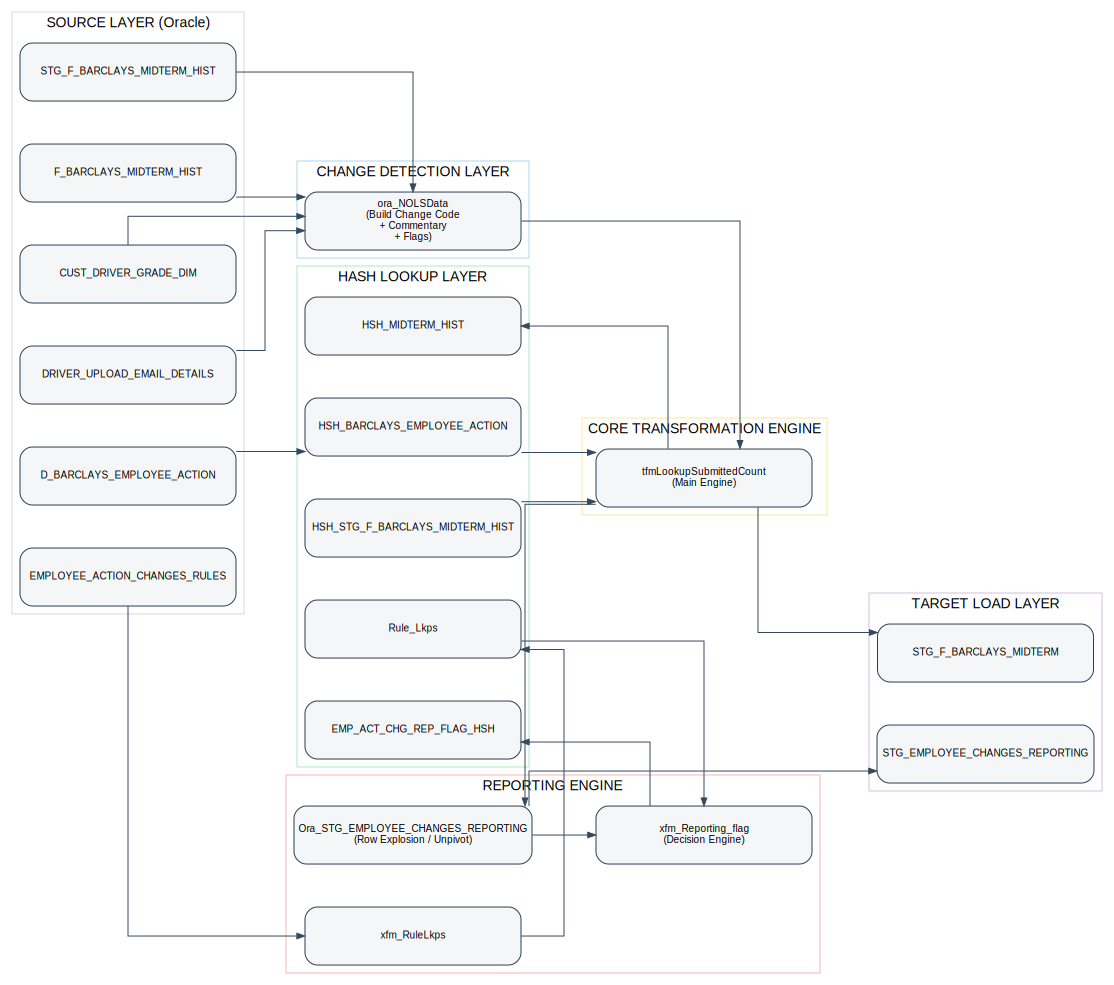

In [ ]:
from graphviz import Source

dot_code = """
digraph LS_Sample_job1_Architecture {

    rankdir=LR;
    splines=ortho;
    nodesep=0.6;
    ranksep=0.8;
    fontname="Helvetica";

    node [
        shape=box,
        style="rounded,filled",
        fillcolor="#F4F6F7",
        color="#2C3E50",
        fontname="Helvetica",
        fontsize=10,
        width=3,
        height=0.8
    ];

    edge [
        color="#34495E",
        arrowsize=0.8
    ];

    // =====================================================
    // 1. SOURCE LAYER
    // =====================================================
    subgraph cluster_source {
        label="SOURCE LAYER (Oracle)";
        color="#D5DBDB";

        src_midterm_hist [label="STG_F_BARCLAYS_MIDTERM_HIST"];
        src_prev_hist    [label="F_BARCLAYS_MIDTERM_HIST"];
        src_grade_dim    [label="CUST_DRIVER_GRADE_DIM"];
        src_upload       [label="DRIVER_UPLOAD_EMAIL_DETAILS"];
        src_action_dim   [label="D_BARCLAYS_EMPLOYEE_ACTION"];
        src_rules        [label="EMPLOYEE_ACTION_CHANGES_RULES"];
    }

    // =====================================================
    // 2. CHANGE DETECTION LAYER
    // =====================================================
    subgraph cluster_change {
        label="CHANGE DETECTION LAYER";
        color="#AED6F1";

        ora_NOLSData [label="ora_NOLSData\n(Build Change Code\n+ Commentary\n+ Flags)"];
    }

    // =====================================================
    // 3. HASH LOOKUP LAYER
    // =====================================================
    subgraph cluster_hash {
        label="HASH LOOKUP LAYER";
        color="#ABEBC6";

        HSH_ACTION [label="HSH_BARCLAYS_EMPLOYEE_ACTION"];
        HSH_STG    [label="HSH_STG_F_BARCLAYS_MIDTERM_HIST"];
        HSH_RULES  [label="Rule_Lkps"];
        HSH_MIDTERM[label="HSH_MIDTERM_HIST"];
        HSH_REP    [label="EMP_ACT_CHG_REP_FLAG_HSH"];
    }

    // =====================================================
    // 4. CORE TRANSFORMATION LAYER
    // =====================================================
    subgraph cluster_core {
        label="CORE TRANSFORMATION ENGINE";
        color="#F9E79F";

        tfmLookup [label="tfmLookupSubmittedCount\n(Main Engine)"];
    }

    // =====================================================
    // 5. REPORTING ENGINE LAYER
    // =====================================================
    subgraph cluster_reporting {
        label="REPORTING ENGINE";
        color="#F5B7B1";

        explode_stage [label="Ora_STG_EMPLOYEE_CHANGES_REPORTING\n(Row Explosion / Unpivot)"];
        xfm_rules     [label="xfm_RuleLkps"];
        xfm_flag      [label="xfm_Reporting_flag\n(Decision Engine)"];
    }

    // =====================================================
    // 6. TARGET LAYER
    // =====================================================
    subgraph cluster_target {
        label="TARGET LOAD LAYER";
        color="#D7BDE2";

        tgt_midterm [label="STG_F_BARCLAYS_MIDTERM"];
        tgt_reporting [label="STG_EMPLOYEE_CHANGES_REPORTING"];
    }

    // =====================================================
    // FLOW CONNECTIONS
    // =====================================================

    // Source -> Change
    src_midterm_hist -> ora_NOLSData;
    src_prev_hist    -> ora_NOLSData;
    src_grade_dim    -> ora_NOLSData;
    src_upload       -> ora_NOLSData;

    // Source -> Hash
    src_action_dim -> HSH_ACTION;
    src_rules      -> xfm_rules;

    // Change -> Core
    ora_NOLSData -> tfmLookup;

    // Hash -> Core
    HSH_ACTION -> tfmLookup;
    HSH_STG    -> tfmLookup;

    // Core -> Hash + Reporting
    tfmLookup -> HSH_MIDTERM;
    tfmLookup -> explode_stage;

    // Reporting Flow
    explode_stage -> xfm_flag;
    xfm_rules -> HSH_RULES;
    HSH_RULES -> xfm_flag;

    // Reporting -> Hash
    xfm_flag -> HSH_REP;

    // Final Loads
    tfmLookup -> tgt_midterm;
    explode_stage -> tgt_reporting;
}
"""

graph = Source(dot_code)
graph.render("LS_Sample_job1_Architecture", format="pdf")
graph

In [ ]:
import re
from graphviz import Digraph

def parse_pseudocode(text):
    stages = {}
    dataset_producers = {}

    stage_pattern = r"--- \[(.*?) : (.*?)\]"
    input_pattern = r"Input:\s*←\s*(dataset_\d+)"
    output_pattern = r"Output:\s*→\s*(dataset_\d+)"

    current_stage = None

    for line in text.splitlines():

        stage_match = re.search(stage_pattern, line)
        if stage_match:
            stage_type = stage_match.group(1).strip()
            stage_name = stage_match.group(2).strip()
            current_stage = stage_name

            stages[current_stage] = {
                "type": stage_type,
                "inputs": [],
                "outputs": []
            }
            continue

        if current_stage:
            input_match = re.search(input_pattern, line)
            if input_match:
                stages[current_stage]["inputs"].append(input_match.group(1))

            output_match = re.search(output_pattern, line)
            if output_match:
                dataset = output_match.group(1)
                stages[current_stage]["outputs"].append(dataset)
                dataset_producers[dataset] = current_stage

    return stages, dataset_producers


def build_graph(stages, dataset_producers):
    dot = Digraph(comment="Auto Generated ETL Architecture")
    dot.attr(rankdir="LR")

    # Create stage nodes
    for stage, info in stages.items():
        dot.node(stage, f"{stage}\n({info['type']})")

    # Create connections
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                source_stage = dataset_producers[dataset]
                dot.edge(source_stage, stage)

    return dot

with open("LS_Sample_job1 1 2_detailed_pseudocode.txt", "r") as f:
    pseudo_text = f.read()

stages, producers = parse_pseudocode(pseudo_text)
graph = build_graph(stages, producers)

graph.render("auto_etl_architecture", format="pdf")


'auto_etl_architecture.pdf'

In [ ]:
import re
from graphviz import Digraph

# -----------------------------
# 1️⃣ Layer Classification
# -----------------------------
def classify_layer(stage_type):
    stage_type = stage_type.upper()

    if "ORACLE" in stage_type or "CUSTOM" in stage_type:
        return "SOURCE_TARGET"

    if "HASHED" in stage_type:
        return "HASH"

    if "TRANSFORMER" in stage_type:
        return "TRANSFORM"

    return "OTHER"


# -----------------------------
# 2️⃣ Parse Pseudocode
# -----------------------------
def parse_pseudocode(text):
    stages = {}
    dataset_producers = {}

    stage_pattern = r"--- \[(.*?) : (.*?)\]"
    input_pattern = r"Input:\s*←\s*(dataset_\d+)"
    output_pattern = r"Output:\s*→\s*(dataset_\d+)"

    current_stage = None

    for line in text.splitlines():

        stage_match = re.search(stage_pattern, line)
        if stage_match:
            stage_type = stage_match.group(1).strip()
            stage_name = stage_match.group(2).strip()

            current_stage = stage_name
            stages[current_stage] = {
                "type": stage_type,
                "inputs": [],
                "outputs": [],
                "layer": classify_layer(stage_type)
            }
            continue

        if current_stage:
            input_match = re.search(input_pattern, line)
            if input_match:
                stages[current_stage]["inputs"].append(input_match.group(1))

            output_match = re.search(output_pattern, line)
            if output_match:
                dataset = output_match.group(1)
                stages[current_stage]["outputs"].append(dataset)
                dataset_producers[dataset] = current_stage

    return stages, dataset_producers


# -----------------------------
# 3️⃣ Build Enterprise Graph
# -----------------------------
def build_enterprise_graph(stages, dataset_producers):
    dot = Digraph("ETL_Architecture")
    dot.attr(rankdir="LR", splines="ortho")
    dot.attr("node", shape="box", style="rounded,filled",
             width="3", height="0.8", fontname="Helvetica")

    # Create clusters
    clusters = {
        "SOURCE_TARGET": {"color": "#AED6F1", "label": "SOURCE / TARGET"},
        "TRANSFORM": {"color": "#F9E79F", "label": "TRANSFORMATION"},
        "HASH": {"color": "#ABEBC6", "label": "HASH LOOKUP"},
        "OTHER": {"color": "#D5DBDB", "label": "OTHER"}
    }

    subgraphs = {}

    for layer, props in clusters.items():
        sub = Digraph(name=f"cluster_{layer}")
        sub.attr(label=props["label"], color=props["color"])
        subgraphs[layer] = sub

    # Add nodes to clusters
    for stage, info in stages.items():
        layer = info["layer"]
        label = f"{stage}\n({info['type']})"

        subgraphs[layer].node(stage, label)

    # Add clusters to main graph
    for sub in subgraphs.values():
        dot.subgraph(sub)

    # Add edges
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                source_stage = dataset_producers[dataset]
                dot.edge(source_stage, stage)

    return dot
with open("LS_Sample_job1 1 2_detailed_pseudocode.txt", "r") as f:
    pseudo_text = f.read()

stages, producers = parse_pseudocode(pseudo_text)
graph = build_enterprise_graph(stages, producers)

graph.render("enterprise_auto_etl_architecture", format="pdf")


'enterprise_auto_etl_architecture.pdf'

In [4]:
import re
from graphviz import Digraph

def classify_layer(stage_type):
    stage_type = stage_type.upper()

    if "ORACLE" in stage_type or "CUSTOM" in stage_type:
        return "SOURCE_TARGET"

    if "HASHED" in stage_type:
        return "HASH"

    if "TRANSFORMER" in stage_type:
        return "TRANSFORM"

    return "OTHER"


def parse_pseudocode(text):
    stages = {}
    dataset_producers = {}

    stage_pattern = r"--- \[(.*?) : (.*?)\]"
    input_pattern = r"Input:\s*←\s*(dataset_\d+)"
    output_pattern = r"Output:\s*→\s*(dataset_\d+)"

    current_stage = None

    for line in text.splitlines():

        stage_match = re.search(stage_pattern, line)
        if stage_match:
            stage_type = stage_match.group(1).strip()
            stage_name = stage_match.group(2).strip()

            current_stage = stage_name
            stages[current_stage] = {
                "type": stage_type,
                "inputs": [],
                "outputs": [],
                "layer": classify_layer(stage_type)
            }
            continue

        if current_stage:
            input_match = re.search(input_pattern, line)
            if input_match:
                stages[current_stage]["inputs"].append(input_match.group(1))

            output_match = re.search(output_pattern, line)
            if output_match:
                dataset = output_match.group(1)
                stages[current_stage]["outputs"].append(dataset)
                dataset_producers[dataset] = current_stage

    return stages, dataset_producers


def build_clean_architecture(stages, dataset_producers):
    dot = Digraph("ETL_Architecture", engine="dot")
    dot.attr(rankdir="LR", splines="spline", nodesep="0.8", ranksep="1")

    dot.attr("node",
             shape="box",
             style="rounded,filled",
             fillcolor="#F4F6F7",
             width="3",
             height="0.8")

    # Create nodes
    for stage, info in stages.items():
        label = f"{stage}\n({info['type']})"
        dot.node(stage, label)

    # Create edges
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                source_stage = dataset_producers[dataset]

                # If lookup/hash → do not affect layout
                if "HASH" in stages[source_stage]["layer"]:
                    dot.edge(source_stage, stage,
                             constraint="false",
                             color="gray")

                else:
                    dot.edge(source_stage, stage)

    return dot

with open("Sample_Job1 1 2_detailed_pseudocode.txt", "r") as f:
    pseudo_text = f.read()

stages, producers = parse_pseudocode(pseudo_text)
graph = build_clean_architecture(stages, producers)

# graph.render("enterprise_auto_etl_architecture1", format="pdf")


In [5]:
from collections import defaultdict, deque

def compute_depths(stages, dataset_producers):
    graph = defaultdict(list)
    indegree = defaultdict(int)

    # Build graph
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                parent = dataset_producers[dataset]
                graph[parent].append(stage)
                indegree[stage] += 1

    # Find roots
    queue = deque()
    depth = {}

    for stage in stages:
        if indegree[stage] == 0:
            queue.append(stage)
            depth[stage] = 0

    # BFS for depth
    while queue:
        node = queue.popleft()
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                depth[neighbor] = depth[node] + 1
                queue.append(neighbor)

    return depth

def build_depth_based_graph(stages, dataset_producers):
    dot = Digraph("ETL_Architecture", engine="dot")
    dot.attr(rankdir="LR", splines="spline", nodesep="0.8", ranksep="1")

    dot.attr("node",
             shape="box",
             style="rounded,filled",
             fillcolor="#F4F6F7",
             width="3",
             height="0.8")

    depths = compute_depths(stages, dataset_producers)

    # Group by depth
    levels = defaultdict(list)
    for stage, d in depths.items():
        levels[d].append(stage)

    # Create ranked layers
    for d in sorted(levels):
        with dot.subgraph() as s:
            s.attr(rank="same")
            for stage in levels[d]:
                label = f"{stage}\n({stages[stage]['type']})"
                s.node(stage, label)

    # Add edges
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                parent = dataset_producers[dataset]

                # Lookup edges don't disturb layout
                if "HASH" in stages[parent]["layer"]:
                    dot.edge(parent, stage,
                             constraint="false",
                             color="gray")

                else:
                    dot.edge(parent, stage)

    return dot

stages, producers = parse_pseudocode(pseudo_text)
graph = build_depth_based_graph(stages, producers)

graph.render("enterprise_auto_etl_architecture3", format="pdf")


'enterprise_auto_etl_architecture3.pdf'

In [8]:
import re
from graphviz import Digraph
from collections import defaultdict, deque


# =====================================================
# 1️⃣  CLASSIFY STAGE TYPES
# =====================================================

def classify_layer(stage_type):
    stage_type = stage_type.upper()

    if "TRANSFORMER" in stage_type:
        return "TRANSFORM"

    if "HASHED" in stage_type:
        return "HASH"

    if "SEQ" in stage_type:
        return "FILE"

    if "ORACLE" in stage_type or "CUSTOM" in stage_type:
        return "DB"

    return "OTHER"


# =====================================================
# 2️⃣  PARSE PSEUDOCODE
# =====================================================

def parse_pseudocode(text):
    stages = {}
    dataset_producers = {}

    stage_pattern = r"--- \[(.*?) : (.*?)\]"
    input_pattern = r"Input:\s*←\s*(dataset_\d+)"
    output_pattern = r"Output:\s*→\s*(dataset_\d+)"

    current_stage = None

    for line in text.splitlines():

        stage_match = re.search(stage_pattern, line)
        if stage_match:
            stage_type = stage_match.group(1).strip()
            stage_name = stage_match.group(2).strip()

            current_stage = stage_name
            stages[current_stage] = {
                "type": stage_type,
                "inputs": [],
                "outputs": [],
                "layer": classify_layer(stage_type)
            }
            continue

        if current_stage:
            input_match = re.search(input_pattern, line)
            if input_match:
                stages[current_stage]["inputs"].append(input_match.group(1))

            output_match = re.search(output_pattern, line)
            if output_match:
                dataset = output_match.group(1)
                stages[current_stage]["outputs"].append(dataset)
                dataset_producers[dataset] = current_stage

    return stages, dataset_producers


# =====================================================
# 3️⃣  COMPUTE EXECUTION DEPTH (TRUE PIPELINE ORDER)
# =====================================================

def compute_depths(stages, dataset_producers):

    graph = defaultdict(list)
    indegree = defaultdict(int)

    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                parent = dataset_producers[dataset]
                graph[parent].append(stage)
                indegree[stage] += 1

    depth = {}
    queue = deque()

    for stage in stages:
        if indegree[stage] == 0:
            queue.append(stage)
            depth[stage] = 0

    while queue:
        node = queue.popleft()
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                depth[neighbor] = depth[node] + 1
                queue.append(neighbor)

    return depth


# =====================================================
# 4️⃣  BUILD STRICT LEFT→RIGHT ARCHITECTURE
# =====================================================

def build_strict_left_to_right(stages, dataset_producers):

    dot = Digraph("ETL_Flow", engine="dot")

    dot.attr(rankdir="LR")
    dot.attr(splines="spline")
    dot.attr(nodesep="0.8")
    dot.attr(ranksep="1.2")

    dot.attr("node",
             shape="box",
             style="rounded,filled",
             fillcolor="#F4F6F7",
             width="3",
             height="0.8")

    depths = compute_depths(stages, dataset_producers)

    # Detect final target nodes (no outgoing edges)
    outgoing = defaultdict(int)
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                parent = dataset_producers[dataset]
                outgoing[parent] += 1

    targets = [s for s in stages if outgoing[s] == 0]

    # Move final DB targets one level deeper
    max_depth = max(depths.values())
    for t in targets:
        if stages[t]["layer"] == "DB":
            depths[t] = max_depth + 1

    # Group nodes by depth
    levels = defaultdict(list)
    for stage, d in depths.items():
        levels[d].append(stage)

    # Create ranked layers
    for d in sorted(levels):
        with dot.subgraph() as s:
            s.attr(rank="same")
            for stage in levels[d]:
                label = f"{stage}\n({stages[stage]['type']})"

                color = "#F4F6F7"
                if stages[stage]["layer"] == "DB":
                    color = "#AED6F1"
                elif stages[stage]["layer"] == "TRANSFORM":
                    color = "#F9E79F"
                elif stages[stage]["layer"] == "HASH":
                    color = "#ABEBC6"
                elif stages[stage]["layer"] == "FILE":
                    color = "#F5B7B1"

                s.node(stage, label, fillcolor=color)

    # Add edges
    for stage, info in stages.items():
        for dataset in info["inputs"]:
            if dataset in dataset_producers:
                parent = dataset_producers[dataset]

                # HASH lookups should not distort layout
                if stages[parent]["layer"] == "HASH":
                    dot.edge(parent, stage,
                             constraint="false",
                             color="gray")

                else:
                    dot.edge(parent, stage)

    return dot


# =====================================================
# 5️⃣  RUN
# =====================================================

with open("Samle_Job2 1 2_detailed_pseudocode.txt", "r") as f:
    pseudo_text = f.read()

stages, producers = parse_pseudocode(pseudo_text)

graph = build_strict_left_to_right(stages, producers)

graph.render("final_clean_etl_flow2 1 2", format="pdf")


'final_clean_etl_flow2 1 2.pdf'